In [1]:
import os
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import pywt
from tqdm import tqdm
from ast import literal_eval
from scipy.signal import stft, istft
from sklearn.decomposition import NMF
from IPython.display import Audio
from scipy import signal
from scipy.interpolate import interp1d

In [2]:
def hamming_window(N):
    # Definición de la ventana hamming de modo que se pueda generar para un
    # largo de ventana definido
    return np.asarray([0.53836 - 0.46164*np.cos((2*np.pi*i)/N)
                       for i in range(int(N))])


def hann_window(N):
    # Definición de la ventana hamming de modo que se pueda generar para un
    # largo de ventana definido
    return np.asarray([0.5 - 0.5*np.cos((2*np.pi*i)/N)
                       for i in range(int(N))])


def wiener_filter(X, WiHi, W, H, alpha=1):
    '''Aplicación de filtro de Wiener para las componentes obtenidas a 
    partir de la descomposición NMF. Está dada por:
    M_i = (WiHi) ** a / (sum_{i} (WiHi) ** a)
    
    Parameters
    ----------
    X : ndarray
        Señal a descomponer mediante NMF.
    WiHi : ndarray
        Componente i de la descomposición NMF.
    W : ndarray
        Matriz que contiene la información espectral de las componentes.
    H : ndarray
        Matriz que contiene la información temporal de las componentes.
    alpha : int, optional
        Exponente utilizado para cada componente. Por defecto es 1.
    '''
    # Definición del WH
    WH_alpha = np.zeros(X.shape)
    
    for i in range(W.shape[1]):
        WH_alpha += np.outer(W[:,i], H[i]) ** alpha
        
    # Obteniendo la máscara
    mask = np.divide(WiHi ** alpha, WH_alpha + 1e-21)
    
    # Aplicando la máscara al espectrograma original, se obtiene el resultado
    # final del proceso de separación de fuentes
    return mask * X


def raised_cosine_modified(N, beta):
    '''Creación de una ventana tipo pulso coseno elevado.
    
    Parameters
    ----------
    N : int
        Cantidad de puntos de la ventana.
    beta : float
        Parámetro de la función coseno elevado para la apertura de la ventana.
        
    Returns
    -------
    rc_out : ndarray
        Ventana pulso coseno elevado de N puntos con el valor de beta ingresado
    '''
    # Definición de la frecuencia f
    f = np.linspace(-1/2, 1/2, N)
    
    # Control de parámetro para beta
    if beta <= 0:
        beta = 0
    elif beta >= 1:
        beta = 1
    
    # Definición del vector de salida
    rc_out = np.array([])
    
    # Para punto f
    for i in f:
        if abs(i) <= (1 - beta)/2:
            rc_out = np.concatenate((rc_out, [1]))
        elif (1 - beta)/2 < abs(i) <= (1 + beta)/2:
            to_append =  np.cos(np.pi / beta * (abs(i) - (1 - beta)/2))
            rc_out = np.concatenate((rc_out, [to_append]))
        else:
            rc_out = np.concatenate((rc_out, [0]))
            
    return rc_out


def raised_cosine_fading(N, beta, side='right'):
    ''' Creacion de una ventana de desvanecimiento basada en coseno elevado.
    
    Parameters
    ----------
    N : int
        Cantidad de puntos de la ventana.
    beta : float
        Parámetro de la función coseno elevado para la apertura de la ventana.
    side : {'left', 'right'}, optional
        Dirección en la cual se puede usará la ventana. Se recomienda 'right' para
        el final de la señal y 'left' para el comienzo. Por defecto es 'right'.
    
    Returns
    -------
    vanish_window : ndarray
        Ventana de desvanecimiento de N puntos.
    '''    
    # Definición de la frecuencia f
    f = np.linspace(-1, 1, 2*N)
    
    # Control de parámetro para beta
    if beta <= 0:
        beta = 0
    elif beta >= 1:
        beta = 1
    
    # Definición del vector de salida
    rc_out = np.array([])
    
    # Para punto f
    for i in f:
        if abs(i) <= (1 - beta)/2:
            rc_out = np.concatenate((rc_out, [1]))
        elif (1 - beta)/2 < abs(i) <= (1 + beta)/2:
            to_append =  1/2 * (1 + np.cos(np.pi / beta * (abs(i) - (1 - beta)/2)))
            rc_out = np.concatenate((rc_out, [to_append]))
        else:
            rc_out = np.concatenate((rc_out, [0]))
    
    # Selección del lado
    if side == 'right':
        vanish_window = rc_out[N:]
    elif side == 'left':
        vanish_window = 1 - rc_out[N:]
    
    return vanish_window


def db_coef(db):
    return 10 ** (db/20)


def db_attenuation(signal_in, db):
    return signal_in * db_coef(-db)

In [3]:
def decimation_signal(signal_in, N_decimate):
    return signal_in[::N_decimate]


def stretch_signal(signal_in, N_stretch):
    return np.array([signal_in[i//N_stretch] if i%N_stretch == 0 else 0
                     for i in range(len(signal_in) * N_stretch)])


def beta_kaiser(A):
    '''Función por tramos que indica el valor que debe tomar el
    parámetro beta
    
    Parámetros
    - A: Ganancia máxima entre ripple de pasa banda y rechaza 
         banda obtenido anteriormente mediante la parametrización
         
    Referencias
    [1] Digital Signal Processing: Principles, Algorithms, and 
        Applications by J. G. Proakis and D. G. Manolakis.
    '''
    if A < 21:
        return 0
    elif 21 <= A <= 50:
        return 0.5842 * (A - 21) ** 0.4 + 0.07886 * (A - 21)
    else:
        return 0.1102 * (A - 8.7)


def filt_and_correct_group_delay(signal_in, gd, gd_padding, num, den):
    '''Función que permite realizar el proceso de filtrado y de corrección por
    delay de grupo a una señal a filtrar.
    
    Parameters
    ----------
    signal_in : ndarray
        Señal a filtrar y corregir.
    gd : int or float
        Delay de grupo de la señal.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente. Por defecto es "periodic".
    num : int, float, list or ndarray
        Coeficientes del numerador para el filtro.
    den : int, float, list or ndarray
        Coeficientes del denominador para el filtro.
    
    Returns
    -------
    signal_to_filt : ndarray
        Señal que se utiliza para filtrar considerando el gd_padding.
    signal_filtered : ndarray
        Señal filtrada y corregida por el delay de grupo.
    '''
    # Presentación de la señal de entrada
    if gd_padding is None:
        signal_to_filt = signal_in

    elif gd_padding == 'zero':
        signal_to_filt = np.concatenate(([0] * len(signal_in),
                                         signal_in,
                                         [0] * len(signal_in)))
    elif gd_padding == 'periodic':
        signal_to_filt = np.concatenate((signal_in,
                                         signal_in,
                                         signal_in))
    elif gd_padding == 'constant':
        signal_to_filt = np.concatenate(([signal_in[0]] * len(signal_in),
                                         signal_in,
                                         [signal_in[-1]] * len(signal_in)))
    else:
        raise Exception('Opción de padding no disponible. Por favor, intente '
                        'nuevamente')

    # Para poder filtrar el audio
    signal_filtered = signal.lfilter(num, den, signal_to_filt)

    # Si se hace padding, se debe cortar de tal forma que se logre sincro-
    # nizar la señal de entrada en función del delay de grupo
    if gd_padding is not None:
        delay = gd
        
        # Definición de los índices a considerar. Se escogen estos índices
        # ya que se asume que el comportamiento ideal de la señal 3 veces
        # paddeada, se encuentra en el centro del arreglo
        ini_index = int(len(signal_in) + delay)
        end_index = int(2 * len(signal_in) + delay)

        # Recortando
        signal_filtered = signal_filtered[ini_index:end_index]

    return signal_to_filt, signal_filtered


def lowpass_cut_frequency(signal_in, samplerate, freq_stop,
                          signal_ref=None):
    '''Función de filtro pasa bajos que corta en una frecuencia 
    determinada, simplemente haciendo cero las frecuencias más
    altas que la frecuencia de corte.
    
    Parámetros
    - signal_in: Señal de entrada
    - samplerate: Frecuencia de muestreo de la señal
    - freq_stop: Frecuencia de corte de la señal
    - signal_ref: Señal de referencia (se utiliza en caso de que 
                  se busque que la señal de salida sea de un largo
                  distinto al de la señal de entrada, por ejemplo,
                  en un proceso de upsampling)
    '''
    # Condición de inicio
    if signal_ref is None:
        signal_ref = signal_in
    
    # Frecuencia de corte relativa
    w_cut =  freq_stop / samplerate
    # Punto de la frecuencia de corte
    cutpoint = int(w_cut * len(signal_ref))

    # Calculando su transformada de Fourier
    signal_fft = np.fft.fft(signal_in)
    # Componentes de la FFT
    mag = np.abs(signal_fft)
    pha = np.angle(signal_fft)

    # Realización del corte en la frecuencia definida
    mag_cutted = np.concatenate((mag[:cutpoint], 
                                 [0] * (len(signal_in) - cutpoint * 2),
                                 mag[-cutpoint:]))

    # Reconstruyendo la señal
    signal_cutted = mag_cutted * np.exp(1j * pha)

    # Aplicando la trnasformada inversa
    signal_lp = np.real(np.fft.ifft(signal_cutted))
    
    return signal_lp


def highpass_cut_frequency(signal_in, samplerate, freq_stop,
                          signal_ref=None):
    '''Función de filtro pasa altos que corta en una frecuencia 
    determinada, simplemente haciendo cero las frecuencias más
    bajas que la frecuencia de corte.
    
    Parámetros
    - signal_in: Señal de entrada
    - samplerate: Frecuencia de muestreo de la señal
    - freq_stop: Frecuencia de corte de la señal
    - signal_ref: Señal de referencia (se utiliza en caso de que 
                  se busque que la señal de salida sea de un largo
                  distinto al de la señal de entrada, por ejemplo,
                  en un proceso de upsampling)
    '''
    # Condición de inicio
    if signal_ref is None:
        signal_ref = signal_in

    # Frecuencia de corte relativa
    w_cut =  freq_stop / samplerate
    # Punto de la frecuencia de corte
    cutpoint = int(w_cut * len(signal_ref))

    # Calculando su transformada de Fourier
    signal_fft = np.fft.fft(signal_in)
    # Componentes de la FFT
    mag = np.abs(signal_fft)
    pha = np.angle(signal_fft)

    # Realización del corte en la frecuencia definida
    mag_cutted = np.concatenate((([0] * cutpoint), 
                                 mag[cutpoint:-cutpoint],
                                ([0] * cutpoint)))

    # Reconstruyendo la señal
    signal_cutted = mag_cutted * np.exp(1j * pha)

    # Aplicando la trnasformada inversa
    signal_hp = np.real(np.fft.ifft(signal_cutted))

    return signal_hp


def fir_filter_adapted(freq_pass, freq_stop, samplerate, gpass=1,
                       gstop=80, use_exact=True, print_window=True,
                       fir_type='lowpass', method='window', parity='odd', 
                       apply_firwin=False):
    '''Diseño de filtros FIR mediante el método de ventaneo. Esta 
    función retorna los coeficientes h[n] del filtro en el tiempo.
    Este filtro minimiza el orden del filtro seleccionando la 
    ventana más conveniente en base a la declaración en decibeles
    de la ganancia de la rechaza banda.
    
    Parameters
    ----------
    freq_pass : float
        Frecuencia de corte de la pasa banda.
    freq_stop : float
        Frecuencia de corte de la rechaza banda.
    samplerate: int 
        Tasa de muestreo de la señal utilizada.
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    use_exact : bool, optional
        Booleano que indica si se usa el valor exacto de transición entre bandas 
        (delta omega). Por defecto es True
    print_window : bool, optional.
        Si se imprime la ventana seleccionada y su orden. Por defecto es False.
    fir_type : {'lowpass', 'highpass'}, optional
        Filtro FIR a crear, que puede ser pasa bajo o pasa alto. Por defecto es 'lowpass'.
    method : {'window', 'kaiser', 'remez'}, optional
        Método de aplicación del filtro FIR. 'window'es construcción por método de la ventana,
        'kaiser' es construcción por método de ventana kaiser y 'remez' es construcción por 
        algoritmo remez. Por defecto es 'kaiser'.
    parity : {'odd', 'even'}, optional
        Cantidad par o impar de puntos para el filtro. Por defecto es 'odd'.
    apply_firwin : bool, optional
        Si se aplica la función firwin o si se hace manualmente. Por defecto es False.
    
    Returns
    -------
    h_n : ndarray
        Ventana del filtro deseado.
    
    Referencias:
    [1] Digital Signal Processing: Principles, Algorithms, and 
        Applications by J. G. Proakis and D. G. Manolakis.
    [2] Página CCRMA de Julius O. Smith III, disponible en:
        https://ccrma.stanford.edu/~jos/
    '''
    # Definición de los ripples en escala absoluta [1]
    delta_p = (10**(gpass/20) - 1)/(10**(gpass/20) + 1)
    delta_s = (1 + delta_p)/(10**(gstop/20))
    # Se escoge el mínimo delta para el diseño de la
    # ganancia A [1]
    delta = min(delta_p, delta_s)
    
    # Definición de ganancia límite
    A = -20*np.log10(delta) 
    
    # Definición de la frecuencia de corte
    cutoff_freq = (freq_pass + freq_stop) / 2
    # Definición de la frecuencia central angular
    omega_c = 2 * np.pi * cutoff_freq / samplerate
    
    # Definición del ancho de banda delta omega 
    trans_width = abs(freq_pass - freq_stop)
    # Definición del ancho de banda delta omega angular
    band_w = 2 * np.pi * trans_width / samplerate
    
    # Para el procedimiento del filtro FIR mediante ventaneo
    if method == 'window':
        # Definición de las ventanas
        windows = (('rectangular', 21, 4 * np.pi, 1.8 * np.pi),
                   ('bartlett', 26, 8 * np.pi, 6.1 * np.pi),
                   ('hann', 44, 8 * np.pi, 6.2 * np.pi),
                   ('hamming', 53, 8 * np.pi, 6.6 * np.pi),
                   ('blackman', 71, 12 * np.pi, 11 * np.pi))

        # Selección de la ventana
        index_window = np.argmin([abs(i[1] - A) for i in windows])

        # Definición de la ventana elegida
        window_choose = windows[index_window][0]
        
        # Una vez seleccionada la ventana, se escoge el orden del filtro,
        # procurando que el ancho del lóbulo principal no sea más grande
        # que la frecuencia de corte [1][2]
        delta_w = 3 if use_exact else 2
        L = round(windows[index_window][delta_w] / band_w)

        # Definición del orden del polinomio de la función de trans-
        # ferencia (largo del filtro). Mientras que L es el largo de
        # la respuesta al impulso
        M = L - 1
        
    # Para el procedimiento mediante ventana kaiser
    elif method == 'kaiser':
        # Definición de la ventana elegida
        window_choose = 'kaiser' 
        
        # Cálculo del beta
        beta = beta_kaiser(A)
        
        # Estimación del orden del filtro [1]
        M = int(np.ceil((A - 8) / (2.285 * band_w)))
    
    # Para el procedimiento mediante algoritmo remez
    elif method == 'remez':
        # El orden del filtro está dado por la relación empírica 
        # propuesta por Kaiser
        M = (-20*np.log10(np.sqrt(delta_s*delta_p)) - 13)/(2.324*band_w)
        # Definición del parámetro de construcción de la ventana
        K = delta_p/delta_s
        
        # Especificación del filtro
        M = int(np.ceil(M))
        M = M  if M % 2 == 0 else M + 1
        
        # Se define el set de frecuencias crítico para el algotitmo
        # el cual contiene [0, wp, ws, pi], donde todas son divididas
        # en 2*pi (se expresan en "f").
        fo = [0, freq_pass, freq_stop, samplerate/2]
        
        # Este vector contiene los valores que tomarán las amplitudes de
        # las frecuencias de interés definidas anteriormente (cada una 
        # representa un rango, por ejemplo entre 0 y freq_pass -> 1  
        # y entre  freq_stop y samplerate/2 -> 0)
        ao = [1, 0]
        
        # Corresponde a los valores que toma la función W(omega) para 
        # cada banda
        W = [1, K]
        
        # Aplicando entonces Parks-McClellan
        return signal.remez(M + 1, fo, ao, W, fs=samplerate)
    
    # OJO: La opción paridad tiene directa relación con el largo de la 
    # salida L, no con M. Por ende, para 'odd', se hará M par para que
    # L sea impar (y viceversa, ya que L = M + 1).
    if parity == 'odd':
        # Si es que M es par, mantenerlo par, si es que es impar, 
        # sumar 1 (esto para L, no para M)
        M = M if M % 2 == 0 else M + 1
    
    elif parity == 'even':
        # Si es que M es impar, mantenerlo impar, si es que es par, 
        # sumar 1 (esto para L, no para M)
        M = M if M % 2 != 0 else M + 1
    
    else:
        raise Exception('Opción de paridad no válida.')
    
    # Redefiniendo L
    L = M + 1
    
    if print_window:
        print(f'Ventana: {window_choose}\n'
              f'Largo resp. al impulso: {L}')
    
    # Aplicando el filtro
    if apply_firwin:
        if window_choose == 'kaiser':
            window_choose = ('kaiser', beta)
            
        return signal.firwin(L, cutoff_freq, 
                             window=window_choose,
                             pass_zero=fir_type,
                             fs=samplerate)
    else:
        # Selección de ventana
        if window_choose == 'rectangular':
            window = np.ones(L)
        elif window_choose == 'bartlett':
            window = np.bartlett(L)
        elif window_choose == 'hann':
            window = np.hanning(L)
        elif window_choose == 'hamming':
            window = np.hamming(L)
        elif window_choose == 'blackman':
            window = np.blackman(L)
        elif window_choose == 'kaiser':
            window = np.kaiser(L, beta)
        
        # Definición de la respuesta al impulso del filtro pasabajo 
        # ideal
        hd = lambda n: (np.sin(omega_c*(n - M/2))/(np.pi*(n - M/2)))\
                        if (n != M/2) else omega_c/np.pi
        
        # Calculando
        hd_n = np.asarray([hd(i) for i in range(L)])
        return  hd_n * window


def lowpass_filter(signal_in, samplerate, freq_pass, freq_stop,
                   method='fir', fir_method='kaiser', gpass=1, 
                   gstop=80, plot_filter=False, correct_by_gd=True,
                   gd_padding='periodic', normalize=True):
    '''Función que permite crear un filtro pasabajos con una frecuencia
    de corte ingresada por el usuario el cual se aplicará a la señal de
    entrada de la función.
    
    Parámetros
    - signal: Señal a filtrar
    - samplerate: Tasa de muestreo de la señal utilizada
    - freq_pass: Frecuencia de corte de la pasa banda
    - freq_stop: Frecuencia de corte de la rechaza banda
    - cutoff_freq: Frecuencia de corte en radianes (pi representa fs/2)
    - method: Método de filtrado
        - ['fir']: Se implementa mediante un filtro fir
        - ['iir']: Se implementa mediante un filtro iir
        - ['cut']: Se implementa simplemente cortando en la frecuencia de interés
    - fir_method: Método de construcción del filtro FIR
        - ['window']: Construcción por método de la ventana
        - ['kaiser']: Construcción por método de ventana kaiser
        - ['remez']: Construcción por algoritmo remez
    - gpass: Ganancia en dB de la magnitud de la pasa banda
    - gstop: Ganancia en dB de la magnitud de la rechaza banda
    - plot_filter: Booleano que permite graficar la señal a ifiltrar y el filtro
    - correct_by_gd: Booleano que permite corregir la salida del filtro FIR por su
                     retraso de grupo
    - gd_padding: Formato para el padding de la señal de entrada
        - [None]: No se hace padding
        - ['zero']: Se hace padding con "len(signal_in)" ceros a la izquierda y
                    derecha de la señal
        - ['periodic']: Se hace padding copiando la señal 3 veces
        - ['constant']: Se hace padding copiando el primer y el último valor para
                        el caso de la izquierda y la derecha respectivamente
    - normalize: Normalización de la señal de salida
    '''
    # Obtención de los parámetros para cada método
    if method == 'fir':
        num = fir_filter_adapted(freq_pass, freq_stop, samplerate, gpass=gpass,
                                 gstop=gstop, use_exact=True, method=fir_method,
                                 print_window=plot_filter, apply_firwin=False)
        den = 1
        
        # Definición gd
        _, gd_list = signal.group_delay((num, den))
        
        gd = round(np.mean(gd_list))
        
        
    elif method == 'iir':
        num, den = signal.iirdesign(wp=freq_pass / (samplerate/2),
                                    ws=freq_stop / (samplerate/2),
                                    gpass=gpass, gstop=gstop)
        # Se define de facto el padding en None ya que es solo una función para
        # filtros FIR
        gp_padding = None
        
        # Se define correct_by_gd en False ya que no se utilizará en algún caso
        correct_by_gd = False
        
        # Definición gd (ya que su fase no es lineal)
        gd = None
        
    elif method == 'cut':
        signal_filtered =  lowpass_cut_frequency(signal_in, samplerate, 
                                                 freq_stop)
        
        # Se define no plotear dado que no hay filtro (independiente de la entrada)
        plot_filter = False
        
        # Se define de facto el padding en None ya que es solo una función para
        # filtros FIR
        gp_padding = None
        
        # Se define correct_by_gd en False ya que no se utilizará en algún caso
        correct_by_gd = False
        
        # Definición gd (ya solo hay corte, no desfase)
        gd = 0
        
        # Definición de salida num y den
        num = den = None
    
    # Opción corregir por delay de grupo (solo para FIR)
    if correct_by_gd:
        signal_to_filt, signal_filtered =\
            filt_and_correct_group_delay(signal_in, gd, gd_padding, num, den)
    else:
        if method != 'cut':
            # Definición de la señal a filtrar
            signal_to_filt = signal_in
            
            # Filtrando
            signal_filtered = signal.lfilter(num, den, signal_to_filt)
    
    if plot_filter:        
        # Subplot principal para los 2 gráficos
        _, ax = plt.subplots(2,1)
        
        # Graficando la señal
        ax[0].set_title('Señal a filtrar')
        ax[0].plot(signal_to_filt)
        
        # Y obteniendo la función de transferencia h
        w, h = signal.freqz(num, den)
        # Graficando el filtro
        ax[1].set_title('Respuesta en frecuencia del filtro digital')
        magnitude = 20 * np.log10(abs(h))
        ax[1].plot(w, magnitude, 'r')
        ax[1].set_ylabel('Magnitude [dB]', color='r')
        ax[1].set_xlabel('Frequencia [rad/sample]')
        ax[1].set_ylim([min(magnitude), max(magnitude) + 10])
        ax2 = ax[1].twinx()
        angles = np.unwrap(np.angle(h))
        ax2.plot(w, angles, 'b')
        ax2.set_ylabel('Phase (radians)', color='b')
        ax2.axis('tight')
        ax2.set_ylim([min(angles), max(angles)])
        plt.show()
    
    if normalize:
        return (gd, num, den), signal_filtered / max(abs(signal_filtered))
    else:
        return (gd, num, den), signal_filtered
    
    
def downsampling_signal(signal_in, samplerate, freq_pass, freq_stop, 
                        method='lowpass', lp_method='fir',
                        resample_method='interp1d',
                        fir_method='kaiser', gpass=1, gstop=80,
                        correct_by_gd=True, gd_padding='periodic',
                        plot_filter=False, normalize=True):
    '''Función que permite disminuir la cantidad de muestras por 
    unidad de tiempo de una señal dada, en función de la frecuencia
    de corte para el pasabajo. Es decir, dada una frecuencia de corte
    de interés, se resampleará la señal al doble de esa frecuencia.
    
    Parameters
    ----------
    signal_in : list or ndarray
        Señal a submuestrear.
    samplerate : int
        Tasa de muestreo de la señal "signal_in".
    freq_pass : float
        Frecuencia de corte de la pasa banda.
    freq_stop : float
        Frecuencia de corte de la rechaza banda. Esta es la que se toma
        en cuenta al momento de hacer el último corte (por ende, si 
        busca samplear a 2kHz, seleccione este parámetro en 1kHz).
    method : {'lowpass', 'cut'}, optional
        Método utilizado para filtrar la señal. Para 'lowpass', se aplica un filtro pasabajos 
        para evitar aliasing de la señal, luego se submuestrea. Para 'cut', se corta en la 
        frecuencia de interés. Por defecto es 'lowpass'.
    lp_method : {'fir', 'iir', 'cut'}, optional
        Método de filtrado para elección lowpass. Para 'fir' se implementa un filtro FIR.
        Para 'iir' se implementa un filtro IIR. 'cut' es un método no convencional en el que
        se todas las frecuencias filtradas de la magnitud se hacen 0. Por defecto es 'fir'.
    resample_method : {'resample', 'resample poly', 'interp1d', 'decimation'}, optional
        Método usado para resamplear. Para 'resample', se aplica la función resample de scipy.
        Para 'resample_poly', se aplica la función resample_poly de scipy. Para 'interp1d',
        se aplica la función 'interp1d' de scipy. Y para 'decimation' se  realiza una 
        decimación a la señal por un parámetro "N_dec" obtenido automáticamente. Por defecto 
        es 'interp1d'.
    fir_method : {'window', 'kaiser', 'remez'}, optional
        Método de construcción del filtro FIR en caso de seleccionar el método lowpass con 
        filtro FIR. Para 'window', se usa construye por método de la ventana. Para 'kaiser',
        se cosntruye por método de ventana kaiser. Para 'remez', se construye por algoritmo 
        remez. Por defecto se usa 'kaiser'.
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    correct_by_gd : bool, optional. 
        Booleano que permite corregir la salida del filtro FIR  por su retraso de grupo.
        Por defecto es True.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente. Por defecto es "periodic".
    plot_filter : bool
        Activar ploteo del filtro aplicado.
    normalize : bool, optional
        Normalización de la señal. Por defecto es True.
    
    Referencias
    -----------
    [1] https://www.cppsim.com/BasicCommLectures/lec10.pdf
    '''
    # Se calcula el paso de la decimación
    N_dec = round(samplerate / (freq_stop * 2))
    
    # Calculo de la nueva tasa de muestreo
    new_rate = 2 * freq_stop
    
    # Selección del método del pasabajos
    if method == 'lowpass':
        # Aplicando el filtro pasa bajos
        _, signal_lp = lowpass_filter(signal_in, samplerate, freq_pass, 
                                      freq_stop, method=lp_method, 
                                      fir_method=fir_method, gpass=gpass, 
                                      gstop=gstop, plot_filter=plot_filter,
                                      correct_by_gd=correct_by_gd,
                                      gd_padding=gd_padding,
                                      normalize=normalize)
    elif method == 'cut':
        signal_lp = lowpass_cut_frequency(signal_in, samplerate, 
                                          freq_stop)
    else:
        raise Exception('Opción de método no válido. Por favor, ingrese'
                        ' un valor válido.')
    
    # Selección del método de resampleo
    if resample_method == 'resample':
        return new_rate, signal.resample(signal_lp, 
                                         len(signal_lp)//N_dec)
    
    elif resample_method == 'resample_poly':
        return new_rate, signal.resample_poly(signal_lp, 
                                              len(signal_lp)//N_dec, 1)
    
    elif resample_method == 'interp1d':
        # Vector de referencia en el eje "x" del vector original
        x = np.arange(0, len(signal_lp))
        
        # Vector de referencia en el eje "x" del vector de salida
        x_new = np.linspace(0, len(signal_lp) - 1, len(signal_lp)//N_dec)
        
        # Creación de la función que realiza la interpolación
        f = interp1d(x, signal_lp)

        return new_rate, f(x_new)
    
    elif resample_method == 'decimation':
        # Calculo de la nueva tasa de muestreo
        new_rate = samplerate // N_dec
        
        return new_rate, decimation_signal(signal_lp, N_decimate=N_dec)
    

def upsampling_signal(signal_in, samplerate, new_samplerate,
                      N_desired=None, resample_method='interp1d',
                      stret_method='lowpass', lp_method='fir', 
                      fir_method='kaiser', trans_width=50, gpass=1, gstop=80, 
                      correct_by_gd=True, gd_padding='periodic',
                      plot_filter=False, plot_signals=False,
                      normalize=True):
    '''Función que permite aumentar la cantidad de muestras por 
    unidad de tiempo de una señal dada, en función de la nueva tasa
    de muestreo deseada.
    
    Parameters
    ----------
    signal_in : list or ndarray
        Señal a submuestrear.
    samplerate : int
        Tasa de muestreo de la señal "signal_in".
    new_samplerate : int
        Tasa de muestreo deseada de la señal.
    N_desired : int or NoneType, optional
        Cantidad de puntos deseadas en la señal de salida. Por defecto es None.
    resample_method : {'resample', 'resample poly', 'interp1d', 'stretching'}, optional
        Método usado para resamplear. Para 'resample', se aplica la función resample de scipy.
        Para 'resample_poly', se aplica la función resample_poly de scipy. Para 'interp1d',
        se aplica la función 'interp1d' de scipy. Y para 'stretching' se realiza el 
        estiramiento a la señal por un parámetro "N_st" obtenido automáticamente. Por defecto 
        es 'interp1d'.
    stret_method : {'lowpass', 'cut'}, optional
        Método utilizado para filtrar la señal. Para 'lowpass', se aplica un filtro pasabajos 
        para evitar aliasing de la señal, luego se submuestrea. Para 'cut', se corta en la 
        frecuencia de interés. Por defecto es 'lowpass'.
    lp_method : {'fir', 'iir'}, optional
        Método de filtrado para elección lowpass. Para 'fir' se implementa un filtro FIR.
        Para 'iir' se implementa un filtro IIR. Por defecto es 'fir'.
    fir_method : {'window', 'kaiser', 'remez'}, optional
        Método de construcción del filtro FIR en caso de seleccionar el método lowpass con 
        filtro FIR. Para 'window', se usa construye por método de la ventana. Para 'kaiser',
        se cosntruye por método de ventana kaiser. Para 'remez', se construye por algoritmo 
        remez. Por defecto se usa 'kaiser'.
    trans_width : int 
        Banda de transición entre la frecuencia de corte de la señal original (que representa 
        la frecuencia de corte del rechaza banda) y la pasa banda del filtro aplicado para 
        eliminar las repeticiones [1].
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    correct_by_gd : bool, optional. 
        Booleano que permite corregir la salida del filtro FIR  por su retraso de grupo.
        Por defecto es True.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente. Por defecto es "periodic".
    plot_filter : bool
        Activar ploteo del filtro aplicado.
    plot_signals : bool
        Activar ploteo de la magnitud de las señales.
    normalize : bool, optional
        Normalización de la señal. Por defecto es True.
    
    Referencias
    [1] https://www.cppsim.com/BasicCommLectures/lec10.pdf
    '''
    # Se calcula la cantidad de puntos a añadir en stretch
    N_st = int(new_samplerate / samplerate)
    
    if resample_method == 'stretching':
        # Aplicando stretching
        signal_stretched = stretch_signal(signal_in, N_stretch=N_st)

        # Aplicando zero padding hasta que se obtenga el largo 
        # deseado de la señal
        if N_desired is not None:
            if len(signal_stretched) < N_desired: 
                signal_stretched = np.append(signal_stretched,
                                             [0] * (N_desired \
                                                    - len(signal_stretched)))
            else:
                signal_stretched = signal_stretched[:N_desired]


        if stret_method == 'lowpass':
            # Definición de las bandas del filtro
            freq_stop = samplerate / 2
            freq_pass = freq_stop - trans_width

            # Aplicando el filtro
            _, signal_out = lowpass_filter(signal_stretched, new_samplerate, 
                                           freq_pass, freq_stop, method=lp_method, 
                                           fir_method=fir_method, gpass=gpass, 
                                           gstop=gstop, correct_by_gd=correct_by_gd,
                                           gd_padding=gd_padding,
                                           plot_filter=plot_filter, 
                                           normalize=normalize)    
        elif stret_method == 'cut':
            # Definición de la frecuencia de corte
            freq_stop = samplerate / 2
            # Método de corte
            signal_out = lowpass_cut_frequency(signal_stretched, samplerate, 
                                               freq_stop, signal_ref=signal_in)
        
    elif resample_method == 'resample':
        if N_desired is not None:
            N_out = N_desired
        else:
            N_out = int(len(signal_in) / samplerate * new_samplerate)
        
        signal_out = signal.resample(signal_in, N_out)
    
    elif resample_method == 'resample_poly':
        # Aplicando zero padding hasta que se obtenga el largo 
        # deseado de la señal
        if N_desired is not None:
            N_out = N_desired
        else:
            N_out = int(len(signal_in) / samplerate * new_samplerate)
        
        # Señal resampleada
        signal_out = signal.resample_poly(signal_in, N_out, len(signal_in))
    
    elif resample_method == 'interp1d':
        # Vector de referencia en el eje "x" del vector original
        x = np.arange(0, len(signal_in))
        
        if N_desired is not None:
            N_out = N_desired
        else:
            N_out = int(len(signal_in) / samplerate * new_samplerate)
        
        # Vector de referencia en el eje "x" del vector de salida
        x_new = np.linspace(0, len(signal_in) - 1, N_out)
        
        # Creación de la función que realiza la interpolación
        f = interp1d(x, signal_in)
        
        # Definición de la señal de salida
        signal_out = f(x_new)
    
    if plot_signals:
        plt.subplot(3,1,1)
        plt.plot(abs(np.fft.fft(signal_in)))
        plt.title('Magnitud señal de entrada')

        plt.subplot(3,1,2)
        plt.plot(abs(np.fft.fft(signal_stretched)))
        plt.title('Magnitud señal stretched')

        plt.subplot(3,1,3)
        plt.plot(abs(np.fft.fft(signal_out)))
        plt.title('Magnitud señal salida')

        plt.show()
    
    if normalize:
        return signal_out / max(abs(signal_out))
    else:
        return signal_out


In [4]:
def nmf_applied_interest_segments(dir_file, assign_method='manual', n_components=2, 
                                  N=2048, N_lax=1500, N_fade=500, noverlap=1024,
                                  window='hamming', whole=False, alpha_wiener=1, 
                                  wiener_filt=True, init='random', solver='cd', beta=2,
                                  tol=1e-4, max_iter=200, alpha_nmf=0, l1_ratio=0,
                                  random_state=0, W_0=None, H_0=None, 
                                  plot_segments=False):
    '''Función que permite obtener la descomposición NMF de una señal (ingresando su
    ubicación en el ordenador) 
    
    Parameters
    ----------
    dir_file : str
        Dirección del archivo de audio a segmentar.
    assign_method : {'auto', 'manual'}, optional
        Método de separación de sonidos. Para 'auto', se utiliza una lista de etiquetas
        creadas manualmente. Para 'manual' se etiqueta segmento a segmento cada componente, 
        las cuales son guardadas en un archivo .txt. Por defecto es 'manual'.
    n_components : int, optional
        Cantidad de componentes a separar la señal. Por defecto es 2.
    N : int, optional
        Cantidad de puntos utilizados en cada ventana de la STFT. Por defecto es 2048.
    N_lax : int, optional
        Cantidad de puntos adicionales que se consideran para cada lado más allá de los
        intervalos dados. Por defecto es 1500.
    N_fade : int, optional
        Cantidad de puntos utilizados para que la ventana se mezcle con fade. Por defecto
        es 500.
    overlap : float, optional
        Nivel de traslape que existe entre una ventana y la siguiente al calcular la 
        STFT. Por defecto es 0.75 (75%).
    padding : int, optional
        Cantidad de ceros añadidos al final para aplicar zero padding. Por defecto es 0.
    window : {None, 'hamming', 'hann', 'nutall', 'tukey'}, optional
        Opciones para las ventanas a utilizar en el cálculo de cada segmento del STFT.
        En caso de elegir None, se asume la ventana rectangular. Por defecto es 'hamming'.
    whole : bool, optional
        Indica si se retorna todo el espectro de frecuencia de la STFT o solo la mitad 
        (por redundancia). True lo entrega completo, False la mtiad. Por defecto es False.
    alpha_wiener : int, optional
        Exponente alpha del filtro de Wiener. Por defecto es 1.
    wiener_filt : bool, optional
        Indica si se aplica el filtro de wiener una vez separado ambas componentes.
        Por defecto es True.
    **kwargs : Revisar nmf_decomposition para el resto.
    
    Returns
    -------
    resp_signal : ndarray
        Señal respiratoria aproximada mediante la descomposición.
    heart_signal : ndarray
        Señal cardíaca aproximada mediante la descomposición.
    '''
    # Abriendo el archivo de sonido
    signal_in, samplerate = sf.read(f'{dir_file}')
    
    # Definición de la carpeta donde se ubica
    filepath = '/'.join(dir_file.split('/')[:-1])
    
    # Definición del nombre del archivo
    filename = dir_file.strip('.wav').split('/')[-1]
        
    # Definición de la carpeta a guardar los segmentos
    filepath_to_save = os.getcwd()#f'{filepath}/Components/Separation on segments/{filename}'
    
    # Preguntar si es que la carpeta que almacenará las imágenes se ha
    # creado. En caso de que no exista, se crea una carpeta
    if not os.path.isdir(filepath_to_save) and plot_segments:
        os.makedirs(filepath_to_save)
    
    # A partir del nombre del archivo es posible obtener también su lista de intervalos.
    ## Primero se obtiene el nombre del sonido cardíaco a revisar
    file_heart = filename.split(' ')[-1].strip('.wav')
    
    ## Luego se define la dirección del archivo de segmentos
    segment_folder = os.getcwd() #f'Database_manufacturing/db_heart/Manual Combinations'
    
    try:
        ## Y se retorna el archivo de segmentos correspondiente al nombre
        name_file_segment = [i for i in os.listdir(segment_folder) 
                             if i.endswith('.txt') and file_heart in i][0]
        
        ## Se abre el archivo y se obtiene la lista de intervalos
        with open(f'{segment_folder}/{name_file_segment}', 'r', encoding='utf8') as data:
            interval_list = literal_eval(data.readline())
        
    except:
        raise Exception(f'No se logra encontrar el archivo con intervalos cardíacos de '
                        f'{filename}')
    
    # Definición de la señal respiratoria de salida
    resp_signal = np.copy(signal_in)
    # Definición de la señal cardíaca de salida
    heart_signal = np.zeros(len(signal_in))
    
    # Método de trabajo
    if assign_method == 'auto':
        # Se obtienen las componetes a partir de las etiquetas generadas
        with open(f'{filepath_to_save}/Heart comp labels.txt', 'r', encoding='utf8') as data:
            comps_choice = literal_eval(data.readline())['comps_choice']
    
    elif assign_method == 'manual':
        # Si se usa el modo manual, se crea una lista que vaya guardando las etiquetas
        heart_comp_labels = list()
        # Y seleccionar modo plot por defecto
        plot_segments = True
    
    # Aplicando NMF en cada segmento de interés
    for num, interval in enumerate(interval_list, 1):
        # Definición del límite inferior y superior
        lower = interval[0] - N_lax
        upper = interval[1] + N_lax
        
        # Definición del segmento a transformar
        segment = signal_in[lower - N_fade:upper + N_fade]
        
        # Aplicando NMF 
        comps, _, _, W, H = nmf_decomposition(segment, samplerate, 
                                              n_components=n_components, 
                                              N=N, noverlap=noverlap, padding=0,
                                              window=window, whole=whole, 
                                              alpha_wiener=alpha_wiener,
                                              wiener_filt=wiener_filt, init=init, 
                                              solver=solver, beta=beta, tol=tol, 
                                              max_iter=max_iter, alpha_nmf=alpha_nmf, 
                                              l1_ratio=l1_ratio, random_state=random_state,
                                              W_0=W_0, H_0=H_0)
        
        # Graficos
        if plot_segments:
            # Definición del backend para maximizar la ventana. Dependiendo del SO
            # puede variar. Para revisar usar comando matplotlib.get_backend()
            plt.switch_backend('TkAgg')
            
            # Creación del plot
            fig, ax = plt.subplots(1, 3, figsize=(17,7))
            
            # Plots
            ax[0].plot(comps[0], label='Comp 1')
            ax[0].plot(comps[1], label='Comp 2')
            ax[0].plot(signal_in[lower-N_fade:upper+N_fade], label='Original')
            ax[0].legend(loc='upper right')
            ax[0].set_title('Señales')
            
            ax[1].plot(W[:,0], label='Comp 1')
            ax[1].plot(W[:,1], label='Comp 2')
            ax[1].legend(loc='upper right')
            ax[1].set_xlim([0,100])
            ax[1].set_title('Matriz W')
            
            ax[2].plot(H[0], label='Comp 1')
            ax[2].plot(H[1], label='Comp 2')
            ax[2].legend(loc='upper right')
            ax[2].set_title('Matriz H')
            
            # Definición del título
            fig.suptitle(f'Segment #{num}')
            
            # Se guarda la figura
            fig.savefig(f'{filepath_to_save}/Segment {num}.png') 
            
            if assign_method == 'manual':
                # Manager para modificar la figura actual y maximizarla
                manager = plt.get_current_fig_manager()
                manager.window.state('zoomed')
                # Se muestra el gráfico
                plt.show()
            
            # Se cierra la figura
            plt.close()
            
        if assign_method == 'auto':
            # Se obtiene la decisión etiquetada como sonido cardíaco
            heart_decision = comps_choice[num - 1]
        
        elif assign_method == 'manual':
            # Se pregunta para la decisión del sonido cardíaco
            heart_decision = decision_question_in_comps(n_components)
            
            # Se agrega la decisión a la lista de labels
            heart_comp_labels.append(heart_decision)
        
        # Y se complementa para el sonido respiratorio
        resp_decision = 0 if heart_decision == 1 else 1
        
        # Definición de la lista de señales a concatenar con fading para el corazón
        heart_connect = (heart_signal[:lower], comps[heart_decision][:len(segment)],
                         heart_signal[upper:])
        
        # Definición de la lista de señales a concatenar con fading para la respiración
        resp_connect = (resp_signal[:lower], comps[resp_decision][:len(segment)],
                        resp_signal[upper:])
        
        # Aplicando fading para cada uno
        heart_signal = fade_connect_signals(heart_connect, N=N_fade, beta=1)
        resp_signal = fade_connect_signals(resp_connect, N=N_fade, beta=1)
    
    if assign_method == 'manual' and plot_segments:
        # Finalmente, se escribe las etiquetas de las componentes
        with open(f'{filepath_to_save}/Heart comp labels.txt', 'a', encoding='utf8') as data:
            # Definición del diccionario de información a guardar
            dic_to_save = {'n_components': n_components, 'N': N, 'N_lax': N_lax,
                           'N_fade': N_fade, 'overlap': overlap, 'padding': 0,
                           'window': window, 'whole': whole, 'alpha_wiener': alpha_wiener,
                           'wiener_filt': wiener_filt, 'init': init, 
                           'solver': solver, 'beta': beta, 'tol': tol, 
                           'max_iter': max_iter, 'alpha_nmf': alpha_nmf, 
                           'l1_ratio': l1_ratio, 'random_state': random_state,
                           'heart_comp_labels': heart_comp_labels}
            
            # Guardando
            data.write(str(dic_to_save))

    return resp_signal, heart_signal


def nmf_decomposition_denoising(signal_in, samplerate, n_components=2, N=2048, noverlap=1024, 
                                iter_prom=1, padding=0, window='hann', whole=False, alpha_wiener=1,  
                                filter_out='wiener', init='random', solver='cd', beta=2,
                                tol=1e-4, max_iter=200, alpha_nmf=0, l1_ratio=0,
                                random_state=0, W_0=None, H_0=None, same_outshape=True,
                                plot_spectrogram=False, scale='abs', db_basys=1e-15, 
                                wav_denoising=False, wavelet='db4', level=10, 
                                threshold_criteria='soft', threshold_delta='universal', 
                                log_base='e'):
    '''Función que permite separar una señal utilizando la descomposición NMF,
    la cual usa como entrada al sistema el espectrograma de la señal de audio.
    Además utiliza todos los parámetros relevantes para este estudio del comando
    NMF programado en la librería sklearn [2].
        
    Parameters
    ----------
    signal_in : ndarray or list
        Señal a descomponer.
    samplerate : int
        Tasa de muestreo de la señal.
    n_components : int, optional
        Cantidad de componentes a separar la señal. Por defecto es 2.
    N : int, optional
        Cantidad de puntos utilizados en cada ventana de la STFT. Por defecto es 2048.
    noverlap : float, optional
        Cantidad de puntos de traslape que existe entre una ventana y la siguiente al 
        calcular la STFT. Por defecto es 1024.
    iter_prom : int, optional
        Cantidad N de soluciones obtenidas a partir de la descomposición a promediar para
        obtener las matrices W y H. Por defecto es 1.
    padding : int, optional
        Cantidad de ceros añadidos al final para aplicar zero padding. Por defecto es 0.
    window : {None, 'hamming', 'hann', 'nutall', 'tukey'}, optional
        Opciones para las ventanas a utilizar en el cálculo de cada segmento del STFT.
        En caso de elegir None, se asume la ventana rectangular. Por defecto es 'hann'.
    whole : bool, optional
        Indica si se retorna todo el espectro de frecuencia de la STFT o solo la mitad 
        (por redundancia). True lo entrega completo, False la mitad. Por defecto es False.
    alpha_wiener : int, optional
        Exponente alpha del filtro de Wiener. Por defecto es 1.
    filter_out : {None, 'wiener', 'binary'}, optional
        Tipo de filtro utilizado para la reconstrucción de la señal. Si es None, se reconstruye
        directamente utilizando lo obtenido. Si es 'wiener', se aplica un filtro de Wiener. 
        Si es 'binary' se aplica un filtro binario. Por defecto es 'wiener'.
    init : {'random', 'custom'}, optional
        Opción de puntos de inicio de la descomposición. 'random' inicia con puntos al
        azar, y 'custom' permite ingresar matrices en "W_0" y "H_0" como puntos iniciales.
        Por defecto es 'random'.
    solver : {'cd', 'mu'}, optional
        Solver numérico a usar. Por defecto es 'cd'.
    beta : {'frobenius', 'kullback-leibler', 'itakura-saito'}, float or string, optional
        Definición de la beta divergencia. Por defecto es 'frobenius' (o 2).
    tol: float, optional
        Tolerancia de la condición de parada. Por defecto es 1e-4.
    max_iter: int, optional
        Cantidad máxima de iteraciones. Por defecto es 200.
    alpha_nmf: float, optional
        Constante que multiplica los términos de regulación en la resolución del problema.
        Por defecto es 0.
    l1_ratio : float, optional
        Parámetro de regulación usado en 'cd'. Por defecto es 0.
    random_state : int, RandomState instance or None, optional
        En caso de ser un "int", actúa como semilla. Si es una instancia "RandomState",
        la variable es el generador de números aleatorios. Si es "None", el número aleatorio
        es un número aleatorio generado por np.random. Por defecto es None.
    W_0 : None or ndarray, optional
        Punto de inicio para W. Por defecto es None.
    H_0 : None or ndarray, optional
        Punto de inicio para H. Por defecto es None.
    same_outshape : bool, optional
        'True' para que la salida tenga el mismo largo que la entrada. 'False' entrega el
        largo de la señal obtenido después de la STFT. Por defecto es "True".
    scale : {'abs', 'dB'}, optional
        Opción de escala utilizada para la entrada. 'abs' utiliza el espectrograma de la
        señal, mientras que 'dB' utiliza el espectrograma en decibeles. Por defecto es 'abs'.
    db_basys : float, optional
        Valor base del espectrograma en decibeles (para evitar divisiones por cero). 
        Por defecto es 1e-15.
    
    Returns
    -------
    components : list
        Lista que contiene las componentes en el dominio del tiempo.
    Y_list : list
        Lista que contiene las componentes en espectrogramas.
    S : ndarray
        Espectrograma de la señal de entrada.
    W : ndarray
        Matriz W (plantillas espectrales) de la descomposición NMF.
    H : ndarray
        Matriz H (plantillas temporales) de la descomposición NMF.
    
    References
    ----------
    [1] Tutorial: https://ccrma.stanford.edu/~njb/teaching/sstutorial/part2.pdf
    [2] https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
    '''
    # Opción de denoising previo
    if wav_denoising:
        signal_to_spect = wavelet_denoising(signal_in, wavelet=wavelet, mode='periodization', 
                                            level=level, threshold_criteria=threshold_criteria, 
                                            threshold_delta=threshold_delta, min_percentage=None, 
                                            print_delta=False, log_base=log_base,
                                            plot_levels=False, delta=None)
    else:
        signal_to_spect = signal_in

    # Propiedad del overlap
    noverlap = 0 if noverlap <= 0 else noverlap
    noverlap = noverlap if noverlap < N else N - 1
        
    # Obteniendo el espectrograma
    t, f, S = get_spectrogram(signal_to_spect, samplerate, N=N, padding=padding, 
                              noverlap=noverlap, window=window, whole=whole)
    
    # Graficando
    if plot_spectrogram:
        plt.pcolormesh(t, f, 20 * np.log10(abs(S) + db_basys), cmap='inferno')
        plt.colorbar()
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()
    
    # Definiendo la magnitud del espectrograma (elemento a estimar)
    if scale == 'abs':
        X = np.abs(S)
        to_up = 0       #Se define para evitar errores
    elif scale == 'dB':
        X = 20 * np.log10(np.abs(S) + db_basys)
        
        # Sumando el mínimo a todas las entradas (para que todo sea no negativo)
        to_up = abs(np.min(X))
        X += to_up
    else:
        raise Exception('Opción ingresada en "scale" no soportada.')
    
    # Dimensión del espectrograma
    n_row, n_col = X.shape
    
    # Definición de la matriz W y H
    W = np.zeros((n_row, n_components))
    H = np.zeros((n_components, n_col))
    
    for i in range(iter_prom):
        # Definiendo el modelo de NMF
        model = NMF(n_components=n_components, init=init, solver=solver,
                    beta_loss=beta, tol=tol, max_iter=max_iter, 
                    random_state=random_state + i, alpha=alpha_nmf, l1_ratio=l1_ratio)

        # Ajustando W
        if init == 'random':
            W_iter = model.fit_transform(X)
        elif init == 'custom':
            W_iter = model.fit_transform(X, W=W_0, H=H_0)
        else:
            raise Exception('Opción ingresada en "init" no soportada.')

        # Ajustando H
        H_iter = model.components_
        
        # Agregando a W y H
        W += W_iter
        H += H_iter
    
    # Promediando
    W /= iter_prom
    H /= iter_prom
    
    # Filtro de salida
    if filter_out == 'binary':
        components, Y_list = _binary_masking(signal_in, W, H, S, n_components, N=N, 
                                             noverlap=noverlap, window=window, 
                                             whole=whole, same_outshape=same_outshape)
    elif filter_out == 'wiener':
        components, Y_list = _wiener_masking(signal_in, W, H, S, n_components, N=N, 
                                             noverlap=noverlap, window=window, 
                                             whole=whole, alpha_wiener=alpha_wiener,
                                             same_outshape=same_outshape,)
    elif filter_out is None:
        components, Y_list = _no_masking(signal_in, W, H, S, n_components, N=N, 
                                         noverlap=noverlap, window=window, 
                                         whole=whole, same_outshape=same_outshape,
                                         scale=scale)
    else:
        raise Exception('Opción ingresada en "filter_out" no soportada.')
    
    return components, Y_list, S, W, H

In [5]:
def get_spectrogram(signal_in, samplerate, N=512, padding=0, repeat=0, noverlap=0, 
                    window='tukey', whole=False):
    '''Función que permite obtener la STFT de una señal.
    
    Parameters
    ----------
    signal_in : ndarray
        Señal de entrada a transformar.
    samplerate : int
        Tasa de muestreo de la señal de entrada.
    N : int, optional
        Cantidad de puntos a utilizar por ventana. Por defecto es 512.
    padding : int, optional
        Cantidad de puntos de zero padding al final de la señal. Por defecto es 0.
    repeat : int, optional
        Cantidad de veces que se repite la señal en el cálculo de la STFT. Por defecto es 0.
    noverlap : int, optional
        Cantidad de puntos de traslape que se utiliza para calcular la STFT. Por defecto
        es 0.
    window : {'tukey', 'hamming', 'hann', 'nuttall'}, None, optional
        Ventana a utilizar para el cálculo de la STFT. Por defecto es 'tukey'. Con None se
        aplica ventana rectangular.
    whole : bool, optional
        Indica si se calcula la STFT hasta samplerate (True) o hasta samplerate // 2 (False).
        Por defecto es False.
        
    Returns
    -------
    t : ndarray
        Arreglo que indica las etiquetas temporales de la matriz que representa la STFT.
    f : ndarray
        Arreglo que indica las etiquetas frecuenciales de la matriz que representa la STFT.
    S : ndarray
        Espectrograma calculado a partir de la STFT de la señal de entrada.
    '''
    
    # Corroboración de criterios: noverlap <= N - 1
    if N <= noverlap:
        raise Exception('noverlap debe ser menor que N.')
    elif noverlap < 0:
        raise Excepetion('noverlap no puede ser negativo')
    else:
        noverlap = int(noverlap)
        
    # Propiedad de repeat
    repeat = int(repeat) if repeat >= 0 else 0
    
    # Lista donde se almacenará los valores del espectrograma
    to_fft = []
    # Lista de tiempo
    times = []
    
    # Variables auxiliares
    t = 0   # Tiempo
    
    # Definición del paso de avance
    step = N - noverlap
    
    # Si el norverlap es 0, se hacen ventanas 2 muestras más grandes 
    # para no considerar los bordes izquierdo y derecho (que son 0)
    if noverlap == 0:
        N_window = N + 2
    else:
        N_window = N
    
    # Seleccionar ventana.
    if window == 'tukey':
        wind_mask = tukey(N_window)
    elif window == 'hamming':
        wind_mask = hamming_window(N_window)
    elif window == 'hann':
        wind_mask = hann_window(N_window)
    elif window == 'nuttall':
        wind_mask = nuttall(N_window)
    elif window is None:
        wind_mask = np.array([1] * N_window)
    
    # Y se recorta en caso de noverlap cero
    wind_mask = wind_mask[1:-1] if noverlap == 0 else wind_mask
    
    # Definición de bordes de signal_in
    signal_in = np.concatenate((np.zeros(N//2), signal_in, np.zeros(N//2)))
    
    # Iteración sobre el audio
    while signal_in.size != 0:
        # Se corta la cantidad de muestras que se necesite, o bien, las que se
        # puedan cortar
        if len(signal_in) >= N:
            # Se obtienen las N muestras de interés
            signal_frame = signal_in[:N]
            
            # Y se corta la señal para la siguiente iteración
            signal_in = signal_in[step:]
            
        # En la última iteración se añaden ceros para lograr el largo N
        else:
            # Definición del último frame
            last_frame = signal_in[:]
            
            # Se rellena con ceros hasta lograr el largo            
            signal_frame = np.append(last_frame, [0] * (N - len(last_frame)))
            
            # Y se corta la señal para la siguiente iteración
            signal_in = signal_in[:0]
    
        # Agregando a los vectores del espectro
        to_fft.append(signal_frame)
        
        # Agregando al vector de tiempo
        times.append(t)
        t += step/samplerate
    
    # Ventaneando
    signal_wind = np.array(to_fft) * wind_mask

    # Repetición de la señal
    if repeat > 0:
        signal_wind = np.pad(signal_wind, pad_width=((0,0), (repeat * N // 2, repeat * N // 2)),
                             mode='reflect')
    
    # Aplicando padding
    zeros = np.zeros((signal_wind.shape[0], padding), dtype=signal_wind.dtype)
    signal_padded = np.concatenate((signal_wind, zeros), axis=1)

    # Aplicando transformada de fourier
    spect = np.fft.fft(signal_padded)
    
    # Preguntar si se quiere el espectro completo, o solo la mitad (debido a
    # que está reflejado hermitianamente)
    if whole:
        # Generar el vector de frecuencias para cada ventana
        freqs = np.linspace(0, samplerate, N + padding + repeat * 2 * (N // 2))

        # Una vez obtenido el spect_mag y spect_pha, se pasa a matriz
        spect = np.array(spect, dtype=np.complex128)
    else:
        # Generar el vector de frecuencias para cada ventana
        freqs = np.linspace(0, samplerate//2, ( N + padding + repeat * 2 * (N // 2))//2 + 1)

        # Una vez obtenido el spect_mag y spect_pha, se pasa a matriz
        spect = np.array(spect, 
                         dtype=np.complex128)[:, :(N + padding + repeat * 2 * (N // 2))//2 + 1]

    # Escalando
    spect *= np.sqrt(1 / (N * np.sum(wind_mask ** 2)))
    
    # Se retornan los valores que permiten construir el espectrograma 
    # correspondiente
    return times, freqs, spect.T


def get_inverse_spectrogram(X, N=None, padding=0, repeat=0, noverlap=0, window='tukey', 
                            whole=False):
    '''Función que permite obtener la ISTFT de un espectrograma.
    
    Parameters
    ----------
    X : ndarray
        Espectrograma a aplicar la ISTFT
    N : int, optional
        Cantidad de puntos a utilizar por ventana. Por defecto es None, con lo cual
        se asume que el N es la dimensión fila de X.
    padding : int, optional
        Cantidad de puntos de padding al final de la señal. Por defecto es 0.
    repeat : int, optional
        Cantidad de veces que se repite la señal en el cálculo de la STFT. Por defecto es 0.
    noverlap : int, optional
        Cantidad de puntos de traslape que se utiliza para calcular la STFT. Por defecto
        es 0.
    window : {'tukey', 'hamming', 'hann', 'nuttall'}, None, optional
        Ventana a utilizar para el cálculo de la STFT. Por defecto es 'tukey'. Con None se
        aplica ventana rectangular.
    whole : bool, optional
        Indica si se calcula la STFT hasta samplerate (True) o hasta samplerate // 2 (False).
        Por defecto es False.
        
    Returns
    -------
    s_out : ndarray
        Señal en el tiempo de correspondiente a la ISTFT de X.
    '''
    # Preguntar si es que la señal está en el rango 0-samplerate. En caso de 
    # que no sea así, se debe concatenar el conjugado de la señal para 
    # recuperar el espectro. Esto se hace así debido a la propiedad de las 
    # señales reales que dice que la FT de una señal real entrega una señal 
    # hermitiana (parte real par, parte imaginaria impar). Luego, como solo 
    # tenemos la mitad de la señal, la otra parte correspondiente a la señal 
    # debiera ser la misma pero conjugada, para que al transformar esta señal 
    # hermitiana mediante la IFT, se recupere una señal real (correspondiente a 
    # la señal de audio).
    
    # Propiedad de padding y repeat
    padding = int(padding) if padding > 0 else 0
    repeat = int(repeat) if repeat > 0 else 0
    
    if not whole:
        # Se refleja lo existente utilizando el conjugado
        X = np.concatenate((X, np.flip(np.conj(X[1:-1, :]), axis=0)))
            
    # Obtener la dimensión de la matriz
    rows, cols = X.shape
        
    # Corroboración de criterios: noverlap <= N - 1
    if rows <= noverlap:
        raise Exception('noverlap debe ser menor que la dimensión fila.')
    else:
        noverlap = int(noverlap)
    
    # Definición de N dependiendo de la naturaleza de la situación
    if N is None or N > rows:
        N = rows
    
    # Si el norverlap es 0, se hacen ventanas 2 muestras más grandes 
    # para no considerar los bordes izquierdo y derecho (que son 0)
    if noverlap == 0:
        N_window = N + 2
    else:
        N_window = N
    
    # Seleccionar ventana
    if window == 'tukey':
        wind_mask = tukey(N_window)
    elif window == 'hamming':
        wind_mask = hamming_window(N_window)
    elif window == 'hann':
        wind_mask = hann_window(N_window)
    elif window == 'nuttall':
        wind_mask = nuttall(N_window)
    elif window is None:
        wind_mask = np.array([1] * N_window)
        
    # Y se recorta en caso de noverlap cero
    wind_mask = wind_mask[1:-1] if noverlap == 0 else wind_mask
    
    # Destransformando y re escalando se obtiene
    ifft_scaled = np.fft.ifft(X, axis=0) * np.sqrt(N * np.sum(wind_mask ** 2))
    
    # Retirando el padding
    if padding > 0:
        # Se corta el padding
        ifft_scaled = ifft_scaled[:-padding,:]
    
    if repeat > 0:
        ifft_scaled = ifft_scaled[repeat*N//2:-repeat*N//2,:] 
    
    # A partir del overlap, el tamaño de cada ventana de la fft (dimensión fila)
    # y la cantidad de frames a las que se les aplicó la transformación 
    # (dimensión columna), se define la cantidad de muestras que representa la
    # señal original
    step = N - noverlap                     # Tamaño del paso
    total_samples = step * (cols - 1) + N   # Tamaño total del arreglo
    
    # Definición de una lista en la que se almacena la transformada inversa
    inv_spect = np.zeros(total_samples, dtype=np.complex128)
    # Definición de una lista de suma de ventanas cuadráticas en el tiempo
    sum_wind = np.zeros(total_samples, dtype=np.complex128)
    
    # Transformando columna a columna (nótese la división en tiempo por una 
    # ventana definida)
    for i in range(cols):
        beg = i * step
        # Se multiplica por el kernel para la reconstrucción a partir de la
        # ventana aplicada inicialmente. Fuente:
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.istft.html        
        # Agregando al arreglo
        inv_spect[beg:beg+N] += ifft_scaled[:, i]
        
        # Se suma la ventana (que sirve como ponderador)
        sum_wind[beg:beg+N] += wind_mask
    
    # Se corta el padding agregado
    inv_spect = inv_spect[N//2:-N//2]
    sum_wind = sum_wind[N//2:-N//2]
    
    # Finalmente se aplica la normalización por la cantidad de veces que se
    # suma cada muestra en el proceso anterior producto del traslape,
    # utilizando las ventanas correspondientes
    return np.real(np.divide(inv_spect, np.where(sum_wind > 1e-10, sum_wind, 1)))


def nmf_decomposition(signal_in, samplerate, n_components=2, N=2048, noverlap=1024, 
                      iter_prom=1, padding=0, repeat=0, window='hann', whole=False, 
                      alpha_wiener=1, filter_out='wiener', init='random', solver='cd', 
                      beta=2, tol=1e-4, max_iter=200, alpha_nmf=0, l1_ratio=0,
                      random_state=None, W_0=None, H_0=None, same_outshape=True,
                      plot_spectrogram=False, scale='abs', db_basys=1e-15):
    '''Función que permite separar una señal utilizando la descomposición NMF,
    la cual usa como entrada al sistema el espectrograma de la señal de audio.
    Además utiliza todos los parámetros relevantes para este estudio del comando
    NMF programado en la librería sklearn [2].
        
    Parameters
    ----------
    signal_in : ndarray or list
        Señal a descomponer.
    samplerate : int
        Tasa de muestreo de la señal.
    n_components : int, optional
        Cantidad de componentes a separar la señal. Por defecto es 2.
    N : int, optional
        Cantidad de puntos utilizados en cada ventana de la STFT. Por defecto es 2048.
    noverlap : float, optional
        Cantidad de puntos de traslape que existe entre una ventana y la siguiente al 
        calcular la STFT. Por defecto es 1024.
    iter_prom : int, optional
        Cantidad N de soluciones obtenidas a partir de la descomposición a promediar para
        obtener las matrices W y H. Por defecto es 1.
    padding : int, optional
        Cantidad de ceros añadidos al final para aplicar zero padding. Por defecto es 0.
    repeat : int, optional
        Cantidad de veces que se repite la señal en el cálculo de la STFT. Por defecto es 0.
    window : {None, 'hamming', 'hann', 'nutall', 'tukey'}, optional
        Opciones para las ventanas a utilizar en el cálculo de cada segmento del STFT.
        En caso de elegir None, se asume la ventana rectangular. Por defecto es 'hann'.
    whole : bool, optional
        Indica si se retorna todo el espectro de frecuencia de la STFT o solo la mitad 
        (por redundancia). True lo entrega completo, False la mitad. Por defecto es False.
    alpha_wiener : int, optional
        Exponente alpha del filtro de Wiener. Por defecto es 1.
    filter_out : {None, 'wiener', 'binary'}, optional
        Tipo de filtro utilizado para la reconstrucción de la señal. Si es None, se reconstruye
        directamente utilizando lo obtenido. Si es 'wiener', se aplica un filtro de Wiener. 
        Si es 'binary' se aplica un filtro binario. Por defecto es 'wiener'.
    init : {'random', 'custom'}, optional
        Opción de puntos de inicio de la descomposición. 'random' inicia con puntos al
        azar, y 'custom' permite ingresar matrices en "W_0" y "H_0" como puntos iniciales.
        Por defecto es 'random'.
    solver : {'cd', 'mu'}, optional
        Solver numérico a usar. Por defecto es 'cd'.
    beta : {'frobenius', 'kullback-leibler', 'itakura-saito'}, float or string, optional
        Definición de la beta divergencia. Por defecto es 'frobenius' (o 2).
    tol: float, optional
        Tolerancia de la condición de parada. Por defecto es 1e-4.
    max_iter: int, optional
        Cantidad máxima de iteraciones. Por defecto es 200.
    alpha_nmf: float, optional
        Constante que multiplica los términos de regulación en la resolución del problema.
        Por defecto es 0.
    l1_ratio : float, optional
        Parámetro de regulación usado en 'cd'. Por defecto es 0.
    random_state : int, RandomState instance or None, optional
        En caso de ser un "int", actúa como semilla. Si es una instancia "RandomState",
        la variable es el generador de números aleatorios. Si es "None", el número aleatorio
        es un número aleatorio generado por np.random. Por defecto es None.
    W_0 : None or ndarray, optional
        Punto de inicio para W. Por defecto es None.
    H_0 : None or ndarray, optional
        Punto de inicio para H. Por defecto es None.
    same_outshape : bool, optional
        'True' para que la salida tenga el mismo largo que la entrada. 'False' entrega el
        largo de la señal obtenido después de la STFT. Por defecto es "True".
    scale : {'abs', 'dB'}, optional
        Opción de escala utilizada para la entrada. 'abs' utiliza el espectrograma de la
        señal, mientras que 'dB' utiliza el espectrograma en decibeles. Por defecto es 'abs'.
    db_basys : float, optional
        Valor base del espectrograma en decibeles (para evitar divisiones por cero). 
        Por defecto es 1e-15.
    
    Returns
    -------
    components : list
        Lista que contiene las componentes en el dominio del tiempo.
    Y_list : list
        Lista que contiene las componentes en espectrogramas.
    S : ndarray
        Espectrograma de la señal de entrada.
    W : ndarray
        Matriz W (plantillas espectrales) de la descomposición NMF.
    H : ndarray
        Matriz H (plantillas temporales) de la descomposición NMF.
    
    References
    ----------
    [1] Tutorial: https://ccrma.stanford.edu/~njb/teaching/sstutorial/part2.pdf
    [2] https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
    '''
    # Propiedad del overlap
    noverlap = 0 if noverlap <= 0 else noverlap
    noverlap = noverlap if noverlap < N else N - 1
        
    # Obteniendo el espectrograma
    t, f, S = get_spectrogram(signal_in, samplerate, N=N, padding=padding, repeat=repeat, 
                              noverlap=noverlap, window=window, whole=whole)
    
    # Graficando
    if plot_spectrogram:
        plt.pcolormesh(t, f, 20 * np.log10(abs(S) + db_basys), cmap='inferno')
        plt.colorbar()
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()
    
    # Definiendo la magnitud del espectrograma (elemento a estimar)
    if scale == 'abs':
        X = np.abs(S)
        to_up = 0       #Se define para evitar errores
    elif scale == 'dB':
        X = 20 * np.log10(np.abs(S) + db_basys)
        
        # Sumando el mínimo a todas las entradas (para que todo sea no negativo)
        to_up = abs(np.min(X))
        X += to_up
    else:
        raise Exception('Opción ingresada en "scale" no soportada.')
    
    # Dimensión del espectrograma
    n_row, n_col = X.shape
    
    # Definición de la matriz W y H
    W = np.zeros((n_row, n_components))
    H = np.zeros((n_components, n_col))
    
    for i in range(iter_prom):
        # Definiendo el modelo de NMF
        model = NMF(n_components=n_components, init=init, solver=solver,
                    beta_loss=beta, tol=tol, max_iter=max_iter, 
                    random_state=random_state + i, alpha=alpha_nmf, l1_ratio=l1_ratio)

        # Ajustando W
        if init == 'random':
            W_iter = model.fit_transform(X)
        elif init == 'custom':
            W_iter = model.fit_transform(X, W=W_0, H=H_0)
        else:
            raise Exception('Opción ingresada en "init" no soportada.')

        # Ajustando H
        H_iter = model.components_
        
        # Agregando a W y H
        W += W_iter
        H += H_iter
    
    # Promediando
    W /= iter_prom
    H /= iter_prom
    
    # Filtro de salida
    if filter_out == 'binary':
        components, Y_list = _binary_masking(signal_in, W, H, S, n_components, N=N, 
                                             noverlap=noverlap, window=window,
                                             padding=padding, repeat=repeat,
                                             whole=whole, same_outshape=same_outshape)
    elif filter_out == 'wiener':
        components, Y_list = _wiener_masking(signal_in, W, H, S, n_components, N=N, 
                                             noverlap=noverlap, window=window, 
                                             padding=padding, repeat=repeat,
                                             whole=whole, alpha_wiener=alpha_wiener,
                                             same_outshape=same_outshape,)
    elif filter_out is None:
        components, Y_list = _no_masking(signal_in, W, H, S, n_components, N=N, 
                                         noverlap=noverlap, window=window, 
                                         padding=padding, repeat=repeat,
                                         whole=whole, same_outshape=same_outshape,
                                         scale=scale)
    else:
        raise Exception('Opción ingresada en "filter_out" no soportada.')
    
    return components, Y_list, S, W, H


def _binary_masking(signal_in, W, H, S, k, N, noverlap, padding, repeat, window, whole,
                    same_outshape=True, get_inverse=True):
    '''Función que permite aplicar enmascaramiento binario a las componentes obtenidas
    mediante descomposición NMF. Esto se obtiene de la forma:
    M_i = {1 si X_i > X_j donde j in {componentes} y j != i
           0 en otro caso}
    
    Esta máscara, en síntesis, indica dónde se encuentra el máximo de todas las 
    componentes en una entrada (p,q) de la matriz (donde p indica alguna fila y q
    alguna columna). La componente que tenga la entrada (p,q) máxima en comparación
    con las demás componentes, tendrá el valor 1. Así, cuando se recomponga la señal,
    la componente i tendrá el valor de la señal original "S" en (p,q) y ninguna otra
    componente lo tendrá.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal a descomponer.
    W : ndarray
        Matriz que contiene la información espectral de las componentes
    H : ndarray
        Matriz que contiene la información temporal de las componentes
    S : ndarray
        Espectrograma de la señal a descomponer
    k : int
        Cantidad de componentes a descomponer (rango interno)
    noverlap : float
        Cantidad de puntos de traslape que existe entre una ventana y la siguiente al 
        calcular la STFT
    window : {None, 'hamming', 'hann', 'nutall', 'tukey'}
        Opciones para las ventanas a utilizar en el cálculo de cada segmento del STFT.
    whole : bool
        Indica si se retorna todo el espectro de frecuencia de la STFT o solo la mitad 
        (por redundancia). True lo entrega completo, False la mitad.
    same_outshape : bool, optional
        'True' para que la salida tenga el mismo largo que la entrada. 'False' entrega el
        largo de la señal obtenido después de la STFT. Por defecto es "True".
        
    Returns
    -------
    components : list
        Lista que contiene las componentes en el dominio del tiempo.
    Y_list : list
        Lista que contiene las componentes en espectrogramas.
        
    Referencias
    -----------
    [1] ChingShun Lin and Erwin Hasting. Blind Source Separation of Heart and Lung Sounds 
        Based on Nonnegative Matrix Factorization. Department of Electronic and Computer 
        Engineering. 2013.
    [2] Ghafoor Shah, Peter Koch, and Constantinos B. Papadias. On the Blind Recovery of
        Cardiac and Respiratory Sounds. IEEE JOURNAL OF BIOMEDICAL AND HEALTH INFORMATICS, 
        VOL. 19, NO. 1, JANUARY 2015
    '''
    # Definición de la lista para almacenar las fuentes
    sources = np.zeros((W.shape[0], H.shape[1], k))

    # Obteniendo las fuentes y aplicando los filtros
    for i in range(k):
        source_i = np.outer(W[:,i], H[i])
        sources[:,:,i] = source_i

    # Obteniendo el arreglo donde se encuentra cada máximo
    masks_indexes = np.argmax(sources, axis=2)
    
    # Definición de la lista de componentes
    Y_list = list()
    components = list()
        
    for i in range(k):
        Yi = np.where(masks_indexes == i, abs(S), 0)
        
        # Agregando a la lista de componentes
        Y_list.append(Yi)
        
        if get_inverse:
            # Y posteriormente la transformada inversa
            yi = get_inverse_spectrogram(Yi * np.exp(1j * np.angle(S)), 
                                         N=N, noverlap=noverlap, window=window, 
                                         padding=padding, repeat=repeat, whole=whole)

            if same_outshape:
                yi = yi[:len(signal_in)]

            # Agregando a la lista de componentes
            components.append(np.real(yi))
        
        
    return components, Y_list


def _wiener_masking(signal_in, W, H, S, k, N, noverlap, padding, repeat, window, whole, 
                    alpha_wiener, same_outshape=True, get_inverse=True):
    '''Función que permite aplicar enmascaramiento por filtro de Wiener a 
    las componentes obtenidas mediante descomposición NMF.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal a descomponer.
    W : ndarray
        Matriz que contiene la información espectral de las componentes
    H : ndarray
        Matriz que contiene la información temporal de las componentes
    S : ndarray
        Espectrograma de la señal a descomponer
    k : int
        Cantidad de componentes a descomponer (rango interno)
    noverlap : float
        Cantidad de puntos de traslape que existe entre una ventana y la siguiente al 
        calcular la STFT
    window : {None, 'hamming', 'hann', 'nutall', 'tukey'}
        Opciones para las ventanas a utilizar en el cálculo de cada segmento del STFT.
    whole : bool
        Indica si se retorna todo el espectro de frecuencia de la STFT o solo la mitad 
        (por redundancia). True lo entrega completo, False la mitad.
    alpha_wiener : int
        Exponente alpha del filtro de Wiener.
    same_outshape : bool, optional
        'True' para que la salida tenga el mismo largo que la entrada. 'False' entrega el
        largo de la señal obtenido después de la STFT. Por defecto es "True".
        
    Returns
    -------
    components : list
        Lista que contiene las componentes en el dominio del tiempo.
    Y_list : list
        Lista que contiene las componentes en espectrogramas.
        
    Referencias
    -----------
    [1] Canadas-Quesada, F. J., Ruiz-Reyes, N., Carabias-Orti, J., Vera-Candeas, P., &
        Fuertes-Garcia, J. (2017). A non-negative matrix factorization approach based on 
        spectro-temporal clustering to extract heart sounds. Applied Acoustics.
    '''
    # Definición de la lista de componentes
    Y_list = list()
    components = list()
    
    # Obteniendo las fuentes y aplicando los filtros
    for i in range(k):
        source_i = np.outer(W[:,i], H[i])
        
        # Aplicando el filtro de wiener
        filt_source_i = wiener_filter(abs(S), source_i, W, H, alpha=alpha_wiener)
        
        # Aplicando el filtro
        Yi = filt_source_i * np.exp(1j * np.angle(S))
        
        # Agregando a la lista de componentes
        Y_list.append(Yi)
        
        if get_inverse:
            # Y posteriormente la transformada inversa
            yi = get_inverse_spectrogram(Yi, N=N, noverlap=noverlap, window=window, 
                                         padding=padding, repeat=repeat, whole=whole)

            if same_outshape:
                yi = yi[:len(signal_in)]

            # Agregando a la lista de componentes
            components.append(np.real(yi))
    
    return components, Y_list


def _no_masking(signal_in, W, H, S, k, N, noverlap, padding, repeat, window, whole, 
                scale, same_outshape=True, get_inverse=True):
    '''Función que recompone las componentes obtenidas mediante descomposición NMF
    sin aplicar ninguna máscara.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal a descomponer.
    W : ndarray
        Matriz que contiene la información espectral de las componentes
    H : ndarray
        Matriz que contiene la información temporal de las componentes
    S : ndarray
        Espectrograma de la señal a descomponer
    k : int
        Cantidad de componentes a descomponer (rango interno)
    noverlap : float
        Cantidad de puntos de traslape que existe entre una ventana y la siguiente al 
        calcular la STFT
    window : {None, 'hamming', 'hann', 'nutall', 'tukey'}
        Opciones para las ventanas a utilizar en el cálculo de cada segmento del STFT.
    whole : bool
        Indica si se retorna todo el espectro de frecuencia de la STFT o solo la mitad 
        (por redundancia). True lo entrega completo, False la mitad.
    same_outshape : bool, optional
        'True' para que la salida tenga el mismo largo que la entrada. 'False' entrega el
        largo de la señal obtenido después de la STFT. Por defecto es "True".
    
    Returns
    -------
    components : list
        Lista que contiene las componentes en el dominio del tiempo.
    Y_list : list
        Lista que contiene las componentes en espectrogramas.
    '''
    # Criterio de salida
    if scale == 'dB':
        raise Exception('No es posible reconstruir sin máscara en escala dB.')
    
    # Definición de la lista de componentes
    Y_list = list()
    components = list()
    
    # Obteniendo las fuentes y aplicando los filtros
    for i in range(k):
        source_i = np.outer(W[:,i], H[i])
        
        # Aplicando el filtro
        Yi = source_i * np.exp(1j * np.angle(S))
        
        # Agregando a la lista de componentes
        Y_list.append(Yi)
        
        if get_inverse:
            # Y posteriormente la transformada inversa
            yi = get_inverse_spectrogram(Yi, N=N, noverlap=noverlap, window=window, 
                                         padding=padding, repeat=repeat, whole=whole)

            if same_outshape:
                yi = yi[:len(signal_in)]

            # Agregando a la lista de componentes
            components.append(np.real(yi))
            
    return components, Y_list

In [6]:
def generate_dictionary_W(filepath, samplerate_des=44100, n_components=4, N=512, noverlap=1024, 
                          iter_prom=1, padding=0, repeat=0, window='hann', whole=False, alpha_wiener=1,  
                          filter_out='wiener', init='random', solver='cd', beta=2,
                          tol=1e-4, max_iter=200, alpha_nmf=0, l1_ratio=0,
                          random_state=0, W_0=None, H_0=None, same_outshape=True,
                          scale='abs', db_basys=1e-15):
    # Lista de sonidos en el directorio ingresado
    sounds = os.listdir(filepath)
    
    # Definición del arreglo donde se almacenará la información
    W_list = np.empty((0, N//2 + padding//2 + repeat * N // 2 +  1))
    
    for sound in tqdm(sounds, desc='Dictionary', ncols=80):
        # Se abre el archivo cardíaco
        audio, samplerate = sf.read(f'{filepath}/{sound}')
        
        if samplerate > samplerate_des:
            sr_in, audio_in = downsampling_signal(audio, samplerate, 
                                                  freq_pass=samplerate_des//2 - 100, 
                                                  freq_stop=samplerate_des//2, 
                                                  method='lowpass', lp_method='fir',
                                                  resample_method='interp1d',
                                                  fir_method='kaiser', gpass=1, gstop=80,
                                                  correct_by_gd=True, gd_padding='periodic',
                                                  plot_filter=False, normalize=True)
        
        elif samplerate < samplerate_des:
            sr_in, audio_in = upsampling_signal(audio, samplerate, samplerate_des,
                                                N_desired=None, resample_method='interp1d',
                                                stret_method='lowpass', lp_method='fir', 
                                                fir_method='kaiser', trans_width=100, 
                                                gpass=1, gstop=80, 
                                                correct_by_gd=True, gd_padding='periodic',
                                                plot_filter=False, plot_signals=False,
                                                normalize=True)
        
        else:
            sr_in, audio_in = samplerate, audio
        
        # Se aplica NMF
        _, _, _, W, _ = nmf_decomposition(audio_in, sr_in, n_components=n_components, 
                                          N=N, noverlap=noverlap, iter_prom=iter_prom, 
                                          padding=padding, repeat=repeat, window=window, whole=whole, 
                                          alpha_wiener=alpha_wiener, filter_out=filter_out, 
                                          init=init, solver=solver, beta=beta, tol=tol, 
                                          max_iter=max_iter, alpha_nmf=alpha_nmf, 
                                          l1_ratio=l1_ratio, random_state=random_state, 
                                          W_0=W_0, H_0=H_0, same_outshape=same_outshape,
                                          plot_spectrogram=False, scale=scale, 
                                          db_basys=db_basys)
        
        W_list = np.vstack((W_list, W.T))
    
    # Definición del directorio a guardar
    filepath_to_save = f'{scale} scale decomposition/SR {samplerate_des}'
    
    # Corroborar la existencia de la carpeta. Si no, crear una
    if not os.path.isdir(f'{filepath_to_save}'):
        os.makedirs(f'{filepath_to_save}')
    
    # Definición del nombre del archivo
    filename = f'{filepath_to_save}/W_dict_comps{n_components}_N{N}_noverlap'\
               f'{noverlap}_padding{padding}_repeat{repeat}_beta{beta}.npz'
    
    # Guardar la lista en un archivo .npz    
    np.savez(filename, W_list=W_list)
    
    return W_list

In [7]:
%matplotlib notebook
filepath = 'normal_a'

# Parametros
beta_list = [1, 2]
n_components = 4

sr_list = [44100//4]
N_list = [512, 1024, 2048, 4096]
for beta in beta_list:
    print(f'Beta = {beta}')
    for sr_des in sr_list:
        for N in N_list:
            noverlap_list = [int(0.9 * N), int(0.95 * N)]# [int(0.25*N), int(0.5*N), int(0.75 * N)]
            for nov in noverlap_list:
                # Iteración
                _ = generate_dictionary_W(filepath, samplerate_des=sr_des, n_components=n_components, N=N, noverlap=nov, 
                                          iter_prom=1, padding=0, repeat=4, window='hann', whole=False, alpha_wiener=1,  
                                          filter_out='wiener', init='random', solver='mu', beta=beta,
                                          tol=1e-4, max_iter=1000, alpha_nmf=0, l1_ratio=0,
                                          random_state=0, W_0=None, H_0=None, same_outshape=True,
                                          scale='abs', db_basys=1e-15)
print('OK!')

Beta = 1


Dictionary: 100%|███████████████████████████████| 23/23 [08:40<00:00, 22.62s/it]


Beta = 2


Dictionary: 100%|███████████████████████████████| 23/23 [02:54<00:00,  7.58s/it]


OK!


<IPython.core.display.Javascript object>


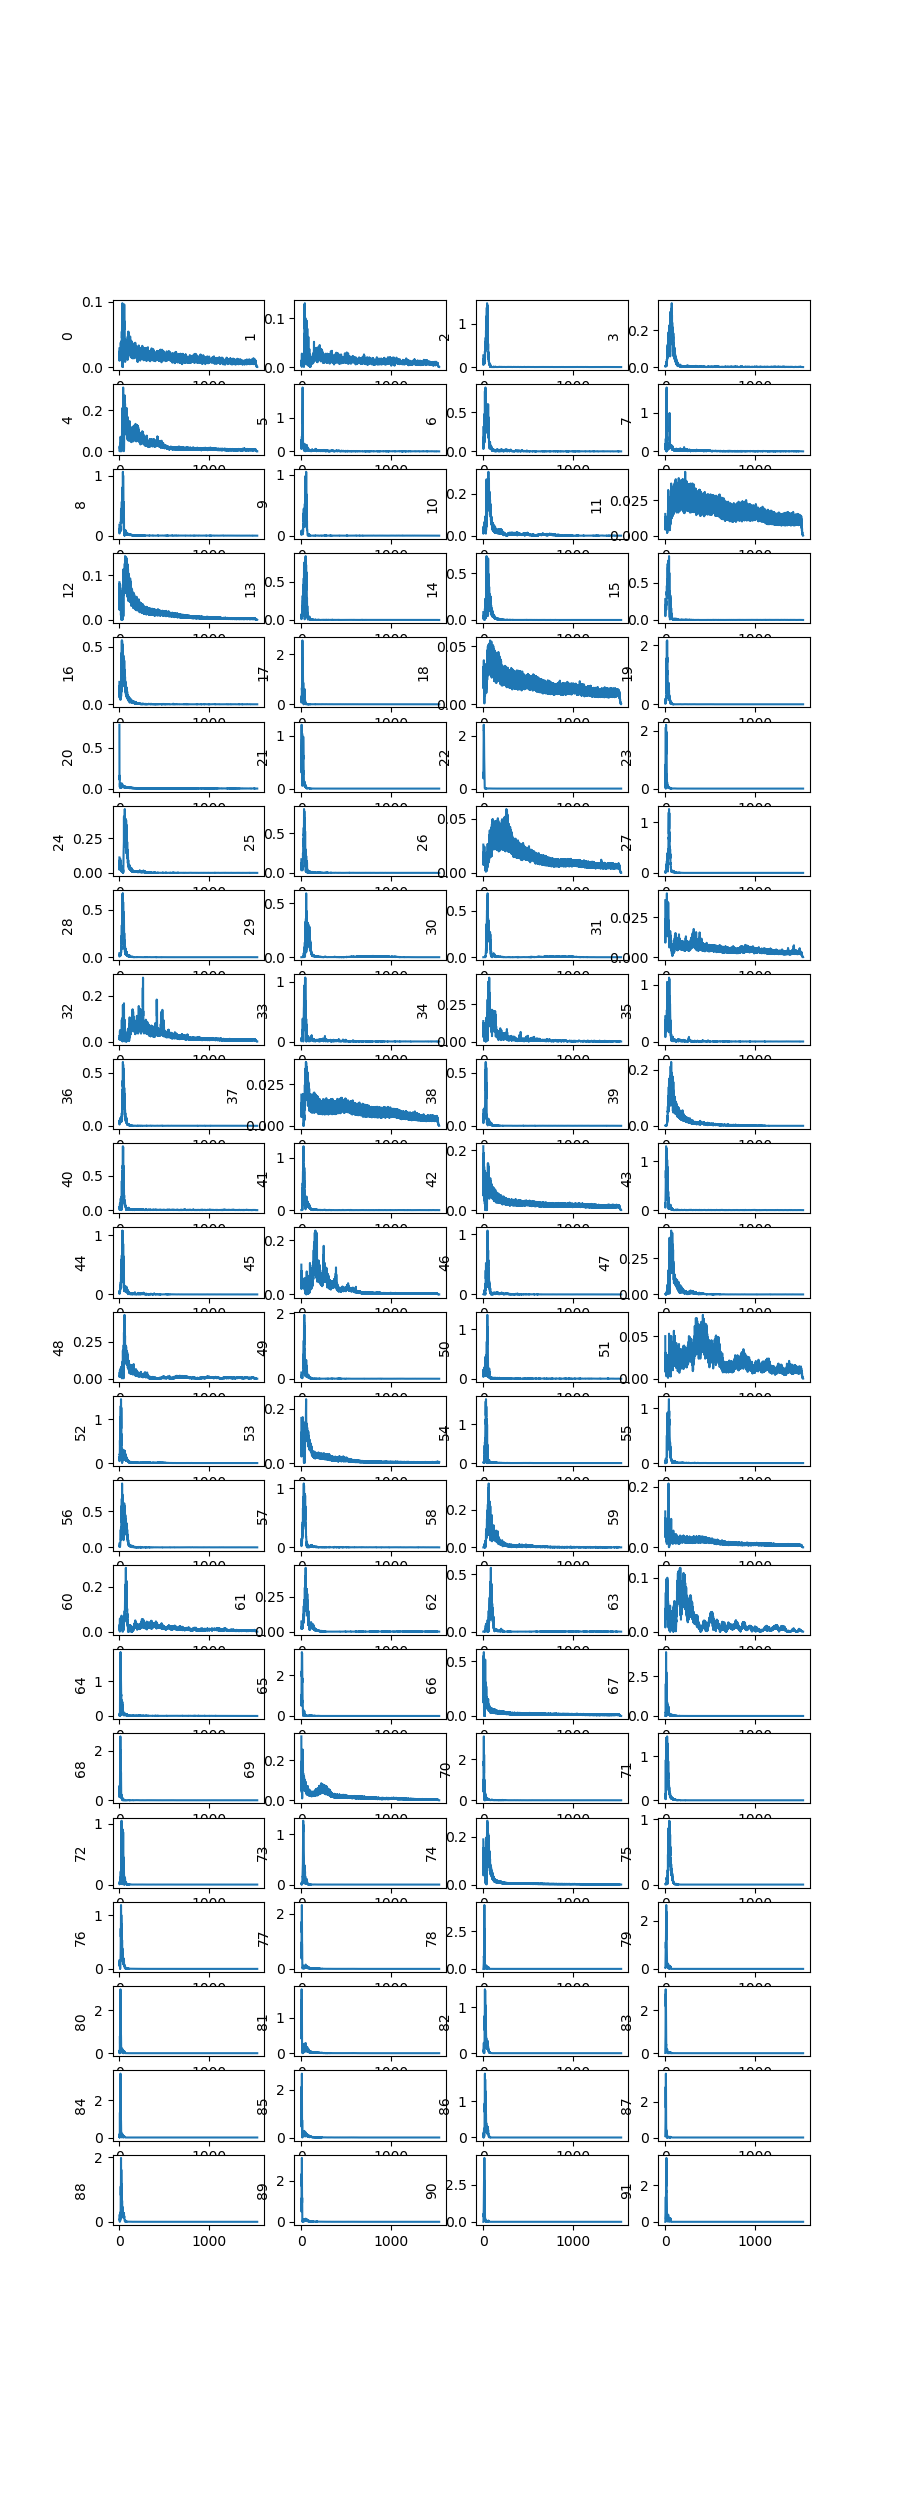

In [11]:
%matplotlib notebook
data = np.load('abs scale decomposition/SR 11025/W_dict_comps4_N1024_noverlap768_padding0_repeat2_beta1.npz')
W_dict = data['W_list']

rows = len(W_dict) // 4
cols = 4

plt.figure(figsize=(9,25))

for i, W_i in enumerate(W_dict):
    plt.subplot(rows, cols, i+1)
    plt.plot(W_i)
    plt.ylabel(i)

plt.show()

In [ ]:
audio, samplerate = sf.read('normal_a/normal__201103221214.wav')

_,_,_,W,_ = nmf_decomposition(audio, samplerate, n_components=2, N=2048, noverlap=1024, 
                          iter_prom=1, padding=0, window='hann', whole=False, alpha_wiener=1,  
                          filter_out='wiener', init='random', solver='cd', beta=2,
                          tol=1e-4, max_iter=200, alpha_nmf=0, l1_ratio=0,
                          random_state=None, W_0=None, H_0=None, same_outshape=True,
                          plot_spectrogram=False, scale='abs', db_basys=1e-15)

# Código para cambiar nombres

In [44]:
sr_list = [44100, 44100//2, 44100//4, 44100//8]

for sr in sr_list:
    filepath = f'abs scale decomposition/SR {sr}'
    names = os.listdir(filepath)
    
    for filename in names:
        if 'repeat' not in filename:
            new_name = f"{'_'.join(filename.split('_')[:-1])}_repeat0_{filename.split('_')[-1]}"
            
            if os.path.exists(f'{filepath}/{filename}'):
                os.rename(f'{filepath}/{filename}',f'{filepath}/{new_name}')